# Music Genre Classification

This notebook implements various a CNN architecture for classifying music genres using the GTZAN dataset. The models use mel-spectrograms as input features.
## Table of Contents

1. Setup and Imports
2. Data Acquisition
3. Spectrogram Generation
4. Data Preparation
5. Data Visualisation
7. Model Architecture 
8. Model Training
9. Model Evaluation and Testing

In [1]:
# Standard libraries
import os
import random
import io
from PIL import Image

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Machine learning
from sklearn.metrics import accuracy_score,\
    f1_score, classification_report,\
    confusion_matrix, ConfusionMatrixDisplay
# PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.datasets as datasets

# Experiment tracking
from comet_ml import start
from comet_ml.integration.pytorch import log_model

# For LSTM model
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm import tqdm
import glob
import time
import soundfile as sf

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Global constants
NUM_CLASSES = 10  # 10 music genres
BATCH_SIZE = 32
LEARNING_RATE_DEFAULT = 0.00001
IMAGE_SIZE = 180  # 180x180 for spectrograms

# Setup GPU Device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Data Acquisition <a id="data-acquisition"></a>

Download and extract the GTZAN dataset from Kaggle.

In [6]:
def setup_kaggle():
    """Set up Kaggle credentials for dataset download"""
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle credentials set up successfully.")

def download_dataset():
    """Download the GTZAN dataset from Kaggle"""
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
    print("Dataset downloaded successfully.")

def extract_dataset():
    """Extract the dataset from the zip file"""
    import zipfile
    with zipfile.ZipFile('gtzan-dataset-music-genre-classification.zip', 'r') as zip_ref:
        zip_ref.extractall('Data')
    print("Dataset extracted successfully.")

def setup_comet(api_key, project_name="MusicGenreClassification", workspace="ariskaralis"):
    """Initialize CometML for experiment tracking"""
    experiment = start(
        api_key=api_key,
        project_name=project_name,
        workspace=workspace
    )
    return experiment

comet_api_key = "yiOG0hwuTZfCFrO1s7eTzxsjW"
# Run setup functions
# setup_kaggle()
# download_dataset()
# extract_dataset()
experiment = setup_comet(api_key=comet_api_key)

COMET INFO: An experiment with the same configuration options is already running and will be reused.


## Spectrogram Generation <a id="spectrogram-generation"></a>

This section generates mel-spectrograms from the audio files and saves them as grayscale images.

In [7]:
def check_if_spectrograms_exist(wav_path, output_path, tolerance=1):
    """
    Check if spectrograms already exist for audio files, with tolerance for a few missing files.

    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images should be saved
        tolerance (int): Number of files that can be missing per genre (default=1)

    Returns:
        bool: True if spectrograms exist (within tolerance), False otherwise
    """
    # If output directory doesn't exist, spectrograms don't exist
    if not os.path.exists(output_path):
        return False

    # Get list of genres from audio files
    audio_genres = [g for g in os.listdir(wav_path) if os.path.isdir(os.path.join(wav_path, g))]

    # Track total files and mismatches
    total_wav_files = 0
    total_png_files = 0
    total_mismatches = 0

    # Check if each genre folder exists in the output directory and has similar number of files
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)

        # Check if genre folder exists in output directory
        if not os.path.exists(spec_genre_path):
            return False

        # Count number of wav files and png files
        wav_files = [f for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [f for f in os.listdir(spec_genre_path) if f.endswith('.png')]

        wav_count = len(wav_files)
        png_count = len(png_files)

        # Check for mismatches
        difference = wav_count - png_count

        # If the difference is more than the tolerance, regenerate
        if difference > tolerance:
            print(f"Genre {genre}: {wav_count} WAV files but only {png_count} PNG files")
            return False

        # If we have more PNGs than WAVs, something is wrong
        if difference < 0:
            print(f"Genre {genre}: More PNG files ({png_count}) than WAV files ({wav_count})! Might need cleaning.")

        total_wav_files += wav_count
        total_png_files += png_count
        total_mismatches += max(0, difference)  # Only count missing files, not excess

    # Check if total mismatches exceed global tolerance
    if total_mismatches > tolerance * len(audio_genres):
        print(f"Total missing spectrograms: {total_mismatches} (tolerance: {tolerance * len(audio_genres)})")
        return False

    # Check for exact file correspondence, not just counts
    for genre in audio_genres:
        audio_genre_path = os.path.join(wav_path, genre)
        spec_genre_path = os.path.join(output_path, genre)

        wav_files = [os.path.splitext(f)[0] for f in os.listdir(audio_genre_path) if f.endswith('.wav')]
        png_files = [os.path.splitext(f)[0] for f in os.listdir(spec_genre_path) if f.endswith('.png')]

        # Check if most wav files have corresponding png files
        files_without_spectrograms = [f for f in wav_files if f not in png_files]
        if len(files_without_spectrograms) > tolerance:
            print(f"Genre {genre} has {len(files_without_spectrograms)} WAV files without spectrograms")
            return False

    print(f"Spectrograms exist: {total_png_files} spectrograms for {total_wav_files} WAV files")
    return True

def create_mel_spectrogram(file_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Create mel spectrogram from an audio file.

    Args:
        file_path (str): Path to the audio file
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands

    Returns:
        tuple: (S_dB, sr) - log-scaled mel spectrogram and sample rate
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Generate mel-spectrogram
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels)

    # Convert to log scale (dB)
    S_dB = librosa.power_to_db(S, ref=np.max)

    return S_dB, sr


def save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size=180):
    """
    Save a spectrogram as a grayscale image.

    Args:
        S_dB (numpy.ndarray): Log-scaled mel spectrogram
        sr (int): Sample rate
        hop_length (int): Number of samples between successive frames
        output_file_path (str): Path where to save the image
        image_size (int): Size of output image (square)

    Returns:
        bool: True if the image was saved successfully
    """
    try:
        # Plot spectrogram
        plt.figure(figsize=(3, 3), dpi=60)
        librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, cmap='gray_r')
        plt.axis('off')  # Remove axis

        # Save image into buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()

        # Load from buffer, resize, and save
        buf.seek(0)
        image = Image.open(buf).convert('L')  # Convert to grayscale ('L' mode)
        image = image.resize((image_size, image_size), Image.Resampling.LANCZOS)

        # Save final image
        image.save(output_file_path)
        return True

    except Exception as e:
        print(f"Error saving spectrogram to {output_file_path}: {str(e)}")
        return False


def process_genre_folder(genre_path, output_genre_path, n_fft=2048, hop_length=512, n_mels=128, image_size=180):
    """
    Process all audio files in a genre folder and create spectrograms.

    Args:
        genre_path (str): Path to the genre folder containing WAV files
        output_genre_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands
        image_size (int): Size of output images

    Returns:
        tuple: (processed_count, error_count) - number of files processed and errors
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_genre_path, exist_ok=True)

    processed_count = 0
    error_count = 0

    for file in os.listdir(genre_path):
        if not file.endswith('.wav'):
            continue

        file_path = os.path.join(genre_path, file)
        image_filename = os.path.splitext(file)[0] + '.png'
        output_file_path = os.path.join(output_genre_path, image_filename)

        # Skip if this specific file already exists
        if os.path.exists(output_file_path):
            continue

        try:
            # Create mel spectrogram
            S_dB, sr = create_mel_spectrogram(file_path, n_fft, hop_length, n_mels)

            # Save spectrogram as image
            if save_spectrogram_as_image(S_dB, sr, hop_length, output_file_path, image_size):
                processed_count += 1
                print(f"Saved spectrogram for {file_path} as {image_filename}")
            else:
                error_count += 1

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            error_count += 1

    return processed_count, error_count


def generate_spectrograms(wav_path, output_path, n_fft=2048, hop_length=512, n_mels=128):
    """
    Generate mel-spectrograms from audio files and save them as grayscale images.

    Args:
        wav_path (str): Path to the directory containing WAV files organized by genre
        output_path (str): Path where spectrogram images will be saved
        n_fft (int): Length of the FFT window
        hop_length (int): Number of samples between successive frames
        n_mels (int): Number of Mel bands

    Returns:
        bool: True if spectrograms were generated, False if they already existed
    """
    # Check if spectrograms already exist
    if check_if_spectrograms_exist(wav_path, output_path):
        print("Spectrogram images already exist. Skipping generation.")
        return False

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    print("Generating mel-spectrograms...")
    genres = os.listdir(wav_path)

    total_processed = 0
    total_errors = 0

    for genre in genres:
        genre_path = os.path.join(wav_path, genre)

        if not os.path.isdir(genre_path):
            continue

        output_genre_path = os.path.join(output_path, genre)

        # Process all files in the genre folder
        processed, errors = process_genre_folder(
            genre_path,
            output_genre_path,
            n_fft,
            hop_length,
            n_mels,
            IMAGE_SIZE
        )

        total_processed += processed
        total_errors += errors

    print(f"Spectrogram generation complete. Generated {total_processed} spectrograms with {total_errors} errors.")
    return True

In [8]:
# Define paths for dataset
wav_dataset_path = ''
spectrogram_path = ''
if str(device) == 'mps':
  wav_dataset_path = 'Data/genres_original'
  spectrogram_path = 'Data/greyscale_spectrograms'
elif str(device) == 'cuda':
  wav_dataset_path = '/content/drive/MyDrive/DLT/Data/genres_original'
  spectrogram_path = '/content/drive/MyDrive/DLT/Data/greyscale_spectrograms'

# Generate spectrograms if needed
spectrograms_generated = generate_spectrograms(
    wav_path=wav_dataset_path,
    output_path=spectrogram_path,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

Generating mel-spectrograms...
Saved spectrogram for Data/genres_original/pop/pop.00027.wav as pop.00027.png
Saved spectrogram for Data/genres_original/pop/pop.00033.wav as pop.00033.png
Saved spectrogram for Data/genres_original/pop/pop.00032.wav as pop.00032.png
Saved spectrogram for Data/genres_original/pop/pop.00026.wav as pop.00026.png
Saved spectrogram for Data/genres_original/pop/pop.00030.wav as pop.00030.png
Saved spectrogram for Data/genres_original/pop/pop.00024.wav as pop.00024.png
Saved spectrogram for Data/genres_original/pop/pop.00018.wav as pop.00018.png
Saved spectrogram for Data/genres_original/pop/pop.00019.wav as pop.00019.png
Saved spectrogram for Data/genres_original/pop/pop.00025.wav as pop.00025.png
Saved spectrogram for Data/genres_original/pop/pop.00031.wav as pop.00031.png
Saved spectrogram for Data/genres_original/pop/pop.00009.wav as pop.00009.png
Saved spectrogram for Data/genres_original/pop/pop.00035.wav as pop.00035.png
Saved spectrogram for Data/genres

/var/folders/pt/69g6_jnn3jn_02xm4dfl99_80000gn/T/ipykernel_86177/3009180679.py:93: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/opt/homebrew/Caskroom/miniconda/base/envs/dlt_labs/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing Data/genres_original/jazz/jazz.00054.wav: 
Saved spectrogram for Data/genres_original/jazz/jazz.00040.wav as jazz.00040.png
Saved spectrogram for Data/genres_original/jazz/jazz.00068.wav as jazz.00068.png
Saved spectrogram for Data/genres_original/jazz/jazz.00097.wav as jazz.00097.png
Saved spectrogram for Data/genres_original/jazz/jazz.00083.wav as jazz.00083.png
Saved spectrogram for Data/genres_original/jazz/jazz.00082.wav as jazz.00082.png
Saved spectrogram for Data/genres_original/jazz/jazz.00096.wav as jazz.00096.png
Saved spectrogram for Data/genres_original/jazz/jazz.00069.wav as jazz.00069.png
Saved spectrogram for Data/genres_original/jazz/jazz.00041.wav as jazz.00041.png
Saved spectrogram for Data/genres_original/jazz/jazz.00055.wav as jazz.00055.png
Saved spectrogram for Data/genres_original/jazz/jazz.00043.wav as jazz.00043.png
Saved spectrogram for Data/genres_original/jazz/jazz.00057.wav as jazz.00057.png
Saved spectrogram for Data/genres_original/jazz/j

## Data Preparation <a id="data-preparation"></a>

This section prepares the data by splitting it into training, validation, and test sets, and creating appropriate data transformations.

In [14]:
def calculate_dataset_statistics(root_dir, indices=None):
    """
    Calculate the mean and standard deviation of the dataset.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        indices (list): Optional indices to use for calculation (for using only training data)

    Returns:
        tuple: (mean, std) of the dataset
    """
    temp_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    # Load dataset with minimal transformations
    temp_dataset = datasets.ImageFolder(root=root_dir, transform=temp_transform)

    # Create subset if indices provided
    if indices is not None:
        dataset_for_stats = Subset(temp_dataset, indices)
    else:
        dataset_for_stats = temp_dataset

    loader = DataLoader(dataset_for_stats, batch_size=32, shuffle=False)

    # Calculate statistics
    sum_pixels = 0.0
    sum_sq_pixels = 0.0
    total_pixels = 0

    for images, _ in loader:
        sum_pixels += images.sum().item()
        sum_sq_pixels += (images ** 2).sum().item()
        total_pixels += images.numel()

    mean = sum_pixels / total_pixels
    var = (sum_sq_pixels / total_pixels) - (mean ** 2)
    std = var ** 0.5

    print(f"Dataset Statistics - Mean: {mean:.4f}, Std: {std:.4f}")
    return mean, std

def create_data_transforms(mean, std):
    """
    Create data transformations for training, validation, and test sets.

    Args:
        mean (float): Mean of the dataset
        std (float): Standard deviation of the dataset

    Returns:
        dict: Dictionary containing transformations for each split
    """
    transform_train = transforms.Compose([
        # Crop random region of the image
        transforms.RandomApply([
            transforms.RandomCrop((80, 80))],
            p=0.1
        ),

        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

        # Convert to tensor
        transforms.ToTensor(),

        # Randomly affine images
        transforms.RandomApply([transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0),
            fill=0)],
            p=0.1
        ),

        # Randomly erase image parts
        transforms.RandomErasing(
            p=0.5,
            scale=(0.004, 0.02),    # ~0.4% to 2% of the total area
            ratio=(20, 200)         # tall/narrow rectangles
        ),

        # Normalise images with calculated mean and std
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_val = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return {
        'train': transform_train,
        'val': transform_val,
        'test': transform_test
    }

def custom_gray_loader(path: str):
    """Load an image as grayscale"""
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

def create_dataloaders(root_dir, transforms_dict, indices_dict, batch_size=32):
    """
    Create dataloaders for training, validation, and test sets.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        transforms_dict (dict): Dictionary containing transformations for each split
        indices_dict (dict): Dictionary containing indices for each split
        batch_size (int): Batch size for the dataloaders

    Returns:
        dict: Dictionary containing dataloaders for each split
    """
    datasets_dict = {}
    dataloaders = {}

    for split in ['train', 'val', 'test']:
        # Create the full dataset with appropriate transform
        full_dataset = datasets.ImageFolder(
            root=root_dir,
            transform=transforms_dict[split],
            loader=custom_gray_loader
        )

        # Create the subset with appropriate indices
        datasets_dict[split] = Subset(full_dataset, indices_dict[split])

        # Create the dataloader with appropriate parameters
        dataloaders[split] = DataLoader(
            datasets_dict[split],
            batch_size=batch_size,
            shuffle=(split == 'train'),  # Only shuffle training data
        )

    return dataloaders

# Main data preparation execution
def prepare_data(root_dir, seed=10, batch_size=32):
    """
    Main function to prepare data for training, validation, and testing.

    Args:
        root_dir (str): Path to the directory containing the images organized by class
        seed (int): Random seed for reproducibility
        batch_size (int): Batch size for the dataloaders

    Returns:
        tuple: (dataloaders, mean, std)
    """
    dataset_wout_transform = datasets.ImageFolder(root=root_dir, transform=None)

    # Split the dataset into 70% training, 20% validation and 10% test sets
    n_total = len(dataset_wout_transform)
    n_train = int(0.7 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val

    indices = list(range(n_total))
    train_subset_indices, val_subset_indices, test_subset_indices = torch.utils.data.random_split(
        indices,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(seed)
    )

    print(f"Dataset split - Total: {n_total}, Training: {n_train}, Validation: {n_val}, Test: {n_test}")

    # Calculate dataset statistics using training set only
    mean, std = calculate_dataset_statistics(root_dir, train_subset_indices.indices)

    # Create data transforms
    transforms_dict = create_data_transforms(mean, std)

    # Create indices dictionary
    indices_dict = {
        'train': train_subset_indices.indices,
        'val': val_subset_indices.indices,
        'test': test_subset_indices.indices
    }

    # Create dataloaders
    dataloaders = create_dataloaders(spectrogram_path, transforms_dict, indices_dict, batch_size)

    return dataloaders, mean, std

# Execute data preparation

dataloaders, mean, std = prepare_data(spectrogram_path, seed=10, batch_size=BATCH_SIZE)

# Extract individual loaders for convenience
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

Dataset split - Total: 999, Training: 699, Validation: 199, Test: 101
Dataset Statistics - Mean: 0.5409, Std: 0.1901


## Data Visualization <a id="data-visualization"></a>

This section provides functions to visualize the dataset samples.

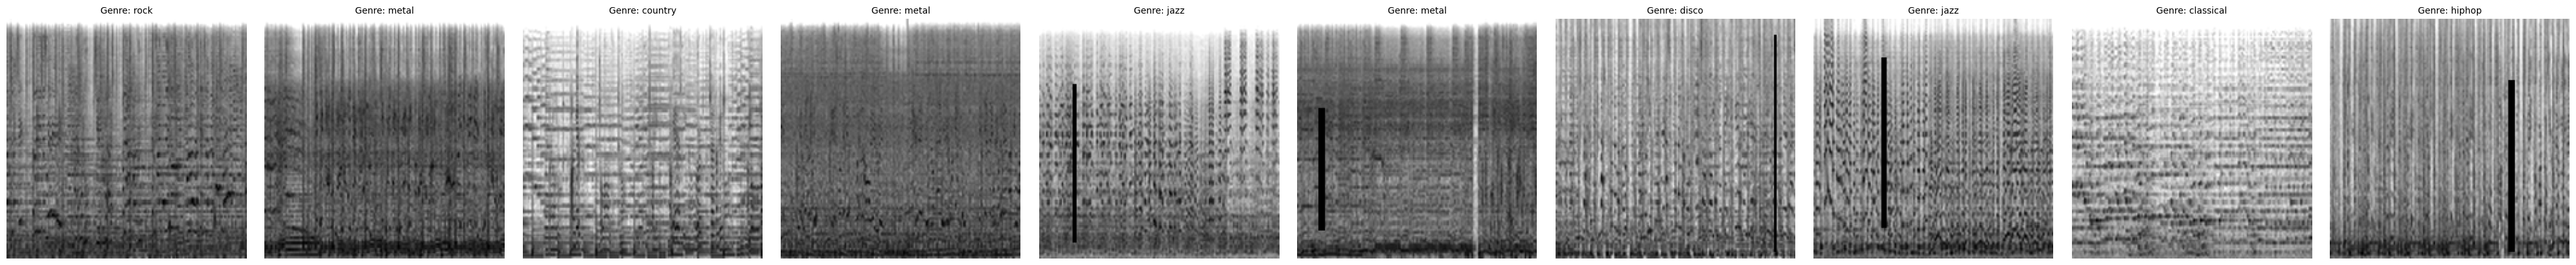

In [10]:
def show_images(loader, mean=0, std=1, num_images=12, figsize=(12, 9), denormalize=True):
    """
    Display a grid of images from a dataloader.

    Args:
        loader (DataLoader): DataLoader to get images from
        mean (float): Mean used for normalization, needed for denormalization
        std (float): Standard deviation used for normalization, needed for denormalization
        num_images (int): Number of images to display
        figsize (tuple): Figure size for the plot
        denormalize (bool): Whether to denormalize images before displaying
    """
    # Get a batch of images
    images, labels = next(iter(loader))

    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    axes = axes.ravel()  # Flatten the grid to make indexing easier

    # Calculate how many images to actually display
    num_to_display = min(num_images, len(images), len(axes))

    # Get class names from the dataset
    class_names = loader.dataset.dataset.classes

    # Plot images
    for idx in range(num_to_display):
        # Get the image and label
        img = images[idx]
        label_idx = labels[idx].item()
        class_name = class_names[label_idx]

        # Convert tensor to numpy for visualization
        img_np = img.cpu().numpy()

        # Handle grayscale images
        if img_np.shape[0] == 1:
            img_np = img_np.squeeze(0)  # Remove the channel dimension

            # Denormalize if requested
            if denormalize:
                img_np = img_np * std + mean

            axes[idx].imshow(img_np, cmap='gray')
        else:
            # Handle RGB images
            if denormalize:
                img_np = img_np * std + mean

            img_np = np.transpose(img_np, (1, 2, 0))  # Change from [C,H,W] to [H,W,C]
            axes[idx].imshow(img_np)

        # Add title and turn off axis
        axes[idx].set_title(f'Genre: {class_name}', fontsize=10)
        axes[idx].axis('off')

    # Hide any unused subplots
    for idx in range(num_to_display, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return class_names

# Show sample images from the training set
num_images = 10
class_names = show_images(
    train_loader,
    mean=mean,
    std=std,
    num_images=num_images,
    figsize=(4*num_images, 4),
    denormalize=True
)

## Model Design, Training and Evaluation Functions


### Model Design

In [23]:
class Net(nn.Module):
    """
    Convolutional Neural Network for image classification.

    Architecture:
    - Conv Layers: 4 (32 → 64 → 128 → 256 filters)
    - Max Pooling: After each pair of conv layers
    - Fully Connected: 256*45*45 → 256 → 10 classes
    """
    def __init__(self, in_channels=1, num_classes=10):
        super(Net, self).__init__()
        # First 2 conv layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)


        # Final 2 conv layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256*45*45, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = Net(in_channels=1, num_classes=NUM_CLASSES).to(device)

### Model Training

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The neural network model
        dataloader (DataLoader): DataLoader for the training set
        criterion (nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimizer
        device (torch.device): Device to run the model on

    Returns:
        tuple: (epoch_loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total

    return epoch_loss, accuracy

In [19]:
def train_model(model, train_loader, val_loader, test_loader, num_epochs, lr, device, experiment=None,
                 optimizer_type='adam', model_name='model', class_names=None):
    """
    Train and evaluate a model.

    Args:
        model (nn.Module): The neural network model
        train_loader (DataLoader): DataLoader for the training set
        val_loader (DataLoader): DataLoader for the validation set
        test_loader (DataLoader): DataLoader for the test set
        num_epochs (int): Number of epochs to train for
        lr (float): Learning rate
        device (torch.device): Device to run the model on
        experiment (comet_ml.Experiment): Comet.ml experiment object
        optimizer_type (str): Type of optimizer to use ('adam' or 'rmsprop')
        model_name (str): Name of the model for logging
        class_names (list): List of class names

    Returns:
        tuple: (model, train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, confusion_matrix)
    """
    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # Log parameters to experiment if provided
    if experiment is not None:
        experiment.log_parameters({
            'model': model_name,
            'optimizer': optimizer_type,
            'lr': lr,
            'batch_size': train_loader.batch_size if hasattr(train_loader, 'batch_size') else 'unknown',
            'epochs': num_epochs
        })

    # Initialize lists to track metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Train for specified number of epochs
    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Log metrics to experiment if provided
        if experiment is not None:
            experiment.log_metric(f"train_loss_{model_name}", train_loss, epoch=epoch)
            experiment.log_metric(f"val_loss_{model_name}", val_loss, epoch=epoch)
            experiment.log_metric(f"train_accuracy_{model_name}", train_accuracy, epoch=epoch)
            experiment.log_metric(f"val_accuracy_{model_name}", val_accuracy, epoch=epoch)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] \n"
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.4f}% | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy*100:.4f}%")
        print("-" * 80)

    # Print best metrics
    best_train_accuracy = max(train_accuracies)
    lowest_train_loss = min(train_losses)
    best_val_accuracy = max(val_accuracies)
    lowest_val_loss = min(val_losses)

    print(f"\nBest Achieved Metrics with {num_epochs} epochs")
    print("=" * 40)
    print(f"Highest Training Accuracy : {best_train_accuracy * 100:.4f}%")
    print(f"Lowest Training Loss      : {lowest_train_loss:.4f}")
    print("-" * 40)
    print(f"Highest Validation Accuracy : {best_val_accuracy * 100:.4f}%")
    print(f"Lowest Validation Loss      : {lowest_val_loss:.4f}")
    print("=" * 40)

    # Evaluate on test set
    test_metric_name = f"{model_name}_test" # Construct a meaningful name
    test_accuracy, micro_f1, macro_f1, conf_m, report_str = test_model(
        model=model,
        dataloader=test_loader,
        device=device,
        class_names=class_names,
        plot_cm=True,
        experiment=experiment,
        metric_name=test_metric_name # Pass the specific name for logging
    )

    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'confusion_matrix': conf_m
    }

    return results_dict

In [20]:
def validate(model, dataloader, criterion, device):
    """
    Validate the model on a validation set.

    Args:
        model (nn.Module): The neural network model
        dataloader (DataLoader): DataLoader for the validation set
        criterion (nn.Module): Loss function
        device (torch.device): Device to run the model on

    Returns:
        tuple: (val_loss, accuracy)
    """
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(dataloader)
    accuracy = val_correct / val_total

    return val_loss, accuracy

### Model Testing

In [21]:
def test_model(model, dataloader, device, class_names=None, plot_cm=True, experiment=None, metric_name=None):
    """
    Test the model on a test set, calculate detailed metrics (Accuracy, Precision, Recall, F1),
    and generate a confusion matrix. This function is designed to work generically
    for various model types (CNN, FCNN, LSTM).

    Args:
        model (nn.Module): The trained neural network model.
        dataloader (DataLoader): DataLoader for the test set.
        device (torch.device): Device to run the model on.
        class_names (list, optional): List of class names for labeling the confusion matrix and report.
        plot_cm (bool, optional): Whether to plot the confusion matrix. Defaults to True.
        experiment (comet_ml.Experiment, optional): Comet.ml experiment object for logging. Defaults to None.
        metric_name (str, optional): Base name to use for logging metrics (e.g., 'net1_test', 'lstm_test').

    Returns:
        tuple: (test_accuracy, micro_f1, macro_f1, confusion_matrix, classification_report_str)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and true labels for metric calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Calculate Metrics ---
    test_accuracy = accuracy_score(y_true, y_pred)
    # Use zero_division=0 to handle cases where a class has no predictions/true labels in the test set slice
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_m = confusion_matrix(y_true, y_pred)
    # Generate classification report (includes precision, recall, f1 per class, and averages)
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4, # Number of digits for precision
        zero_division=0 # How to handle division by zero
    )

    # --- Printing Results ---
    print("-" * 80)
    print(f"Test Results ({metric_name if metric_name else 'Model'}):")
    print("-" * 80)
    print(f'Overall Test Accuracy : {test_accuracy * 100:.2f}%')
    print(f'Micro F1 Score        : {micro_f1:.4f}')
    print(f'Macro F1 Score        : {macro_f1:.4f}')
    print("\nClassification Report:")
    print(report)
    print("-" * 80)

    # --- Logging to Experiment ---
    if experiment is not None:
        log_prefix = f"{metric_name}_" if metric_name else "test_"
        # Log primary metrics
        experiment.log_metric(f"{log_prefix}accuracy", test_accuracy)
        experiment.log_metric(f"{log_prefix}micro_f1", micro_f1)
        experiment.log_metric(f"{log_prefix}macro_f1", macro_f1)
        experiment.log_text(report, metadata={'name': f'{log_prefix}classification_report'})
        experiment.log_confusion_matrix(matrix=conf_m, labels=class_names, title=f'{log_prefix}Confusion Matrix')

    # --- Plotting Confusion Matrix ---
    if plot_cm:
        plt.figure(figsize=(12, 8))
        try:
            # Ensure class_names length matches the number of classes in conf_m if provided
            effective_labels = class_names if class_names is not None and len(class_names) == conf_m.shape[0] else None
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=effective_labels)
            disp.plot(cmap='Blues', xticks_rotation=45)
            title = f'Confusion Matrix ({metric_name})' if metric_name else 'Confusion Matrix on Test Set'
            if effective_labels is None and class_names is not None:
                 title += " (Labels Mismatch)"
                 print(f"Warning: Provided class_names length ({len(class_names)}) doesn't match confusion matrix dimension ({conf_m.shape[0]}). Plotting without labels.")
            plt.title(title)

        except Exception as e: # Catch potential errors during plotting
             print(f"Error plotting confusion matrix: {e}")
             # Fallback plotting without labels
             disp = ConfusionMatrixDisplay(confusion_matrix=conf_m)
             disp.plot(cmap='Blues', xticks_rotation=45)
             plt.title(f'Confusion Matrix ({metric_name}) - Plotting Error' if metric_name else 'Confusion Matrix on Test Set - Plotting Error')

        plt.tight_layout()
        plt.show()

    return test_accuracy, micro_f1, macro_f1, conf_m, report



### Plot Results

In [22]:

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, title_prefix=""):
    """
    Plot the training and validation losses and accuracies.

    Args:
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_accuracies (list): Training accuracies
        val_accuracies (list): Validation accuracies
        title_prefix (str): Prefix for the plot titles
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title_prefix} Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot([acc * 100 for acc in train_accuracies], label='Training Accuracy')
    ax2.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title_prefix} Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


### Training CNN with 50 epochs

Epoch [1/50] 
Train Loss: 2.2418 | Train Accuracy: 18.1688% | Val Loss: 2.1303 | Val Accuracy: 27.1357%
--------------------------------------------------------------------------------
Epoch [2/50] 
Train Loss: 2.0552 | Train Accuracy: 32.7611% | Val Loss: 1.9492 | Val Accuracy: 32.1608%
--------------------------------------------------------------------------------
Epoch [3/50] 
Train Loss: 1.9081 | Train Accuracy: 33.9056% | Val Loss: 1.7675 | Val Accuracy: 45.7286%
--------------------------------------------------------------------------------
Epoch [4/50] 
Train Loss: 1.7875 | Train Accuracy: 37.0529% | Val Loss: 1.6312 | Val Accuracy: 41.7085%
--------------------------------------------------------------------------------
Epoch [5/50] 
Train Loss: 1.6727 | Train Accuracy: 42.2031% | Val Loss: 1.5395 | Val Accuracy: 46.2312%
--------------------------------------------------------------------------------
Epoch [6/50] 
Train Loss: 1.5810 | Train Accuracy: 46.4950% | Val Loss: 1.4

<Figure size 1200x800 with 0 Axes>

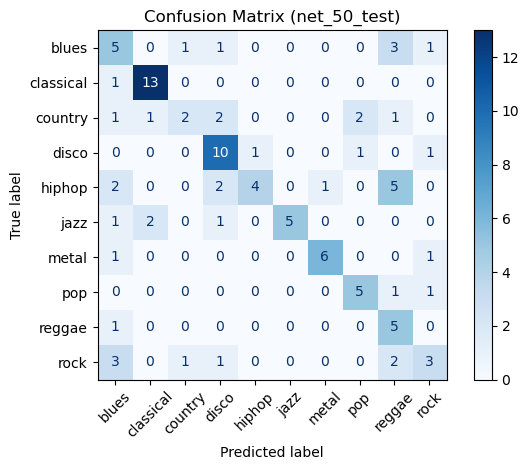

In [24]:
# Train the CNN model for 50 epochs
net_epochs_50 = 50
net_lr = 0.00001

net_results_50 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net_epochs_50,
    lr=net_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net_50',
    class_names=class_names
)

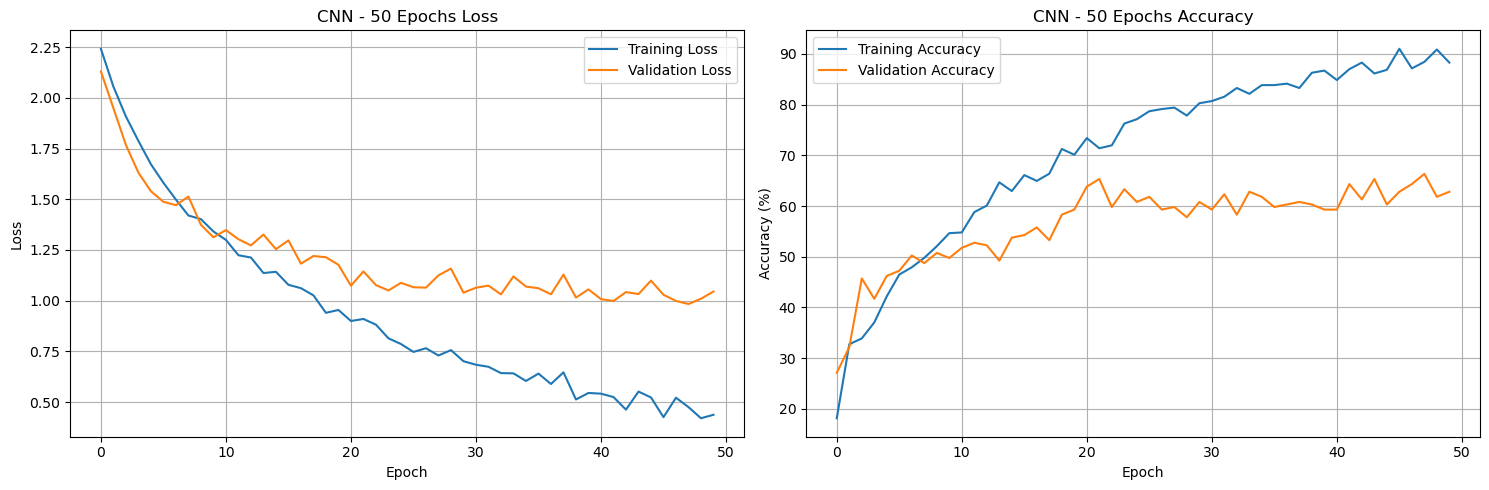

In [25]:
plot_training_history(
    net_results_50['train_losses'],
    net_results_50['val_losses'],
    net_results_50['train_accuracies'],
    net_results_50['val_accuracies'],
    title_prefix="CNN - 50 Epochs"
)

Epoch [1/100] 
Train Loss: 0.5018 | Train Accuracy: 86.6953% | Val Loss: 1.0372 | Val Accuracy: 62.8141%
--------------------------------------------------------------------------------
Epoch [2/100] 
Train Loss: 0.3966 | Train Accuracy: 90.4149% | Val Loss: 1.0378 | Val Accuracy: 59.2965%
--------------------------------------------------------------------------------
Epoch [3/100] 
Train Loss: 0.4873 | Train Accuracy: 87.8398% | Val Loss: 1.0737 | Val Accuracy: 62.3116%
--------------------------------------------------------------------------------
Epoch [4/100] 
Train Loss: 0.4277 | Train Accuracy: 88.8412% | Val Loss: 1.0688 | Val Accuracy: 65.8291%
--------------------------------------------------------------------------------
Epoch [5/100] 
Train Loss: 0.4142 | Train Accuracy: 90.2718% | Val Loss: 0.9785 | Val Accuracy: 63.8191%
--------------------------------------------------------------------------------
Epoch [6/100] 
Train Loss: 0.3600 | Train Accuracy: 91.4163% | Val Los

<Figure size 1200x800 with 0 Axes>

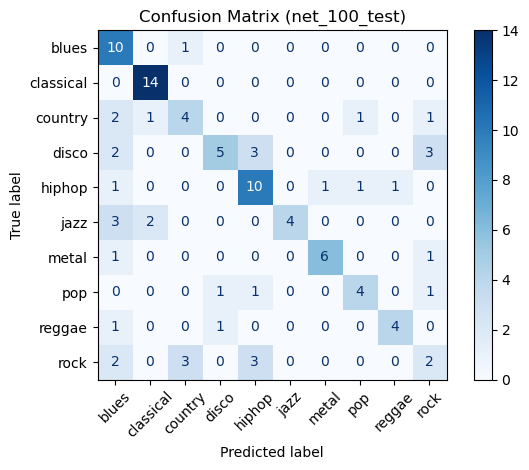

In [26]:
# Train the CNN model for 100 epochs
net_epochs_50 = 100
net_lr = 0.00001

net_results_100 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=net_epochs_50,
    lr=net_lr,
    device=device,
    experiment=experiment,
    optimizer_type='adam',
    model_name='net_100',
    class_names=class_names
)

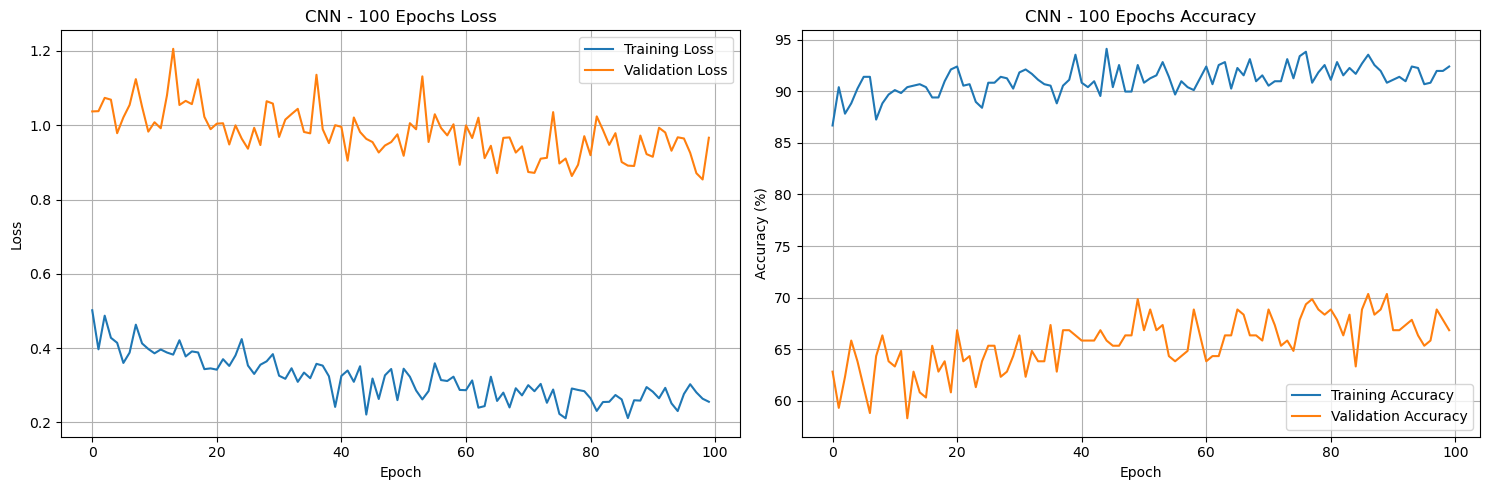

COMET ERROR: Due to connectivity issues, there's an error in processing the heartbeat. The experiment's status updates might be inaccurate until the connection issues are resolved.


In [27]:
plot_training_history(
    net_results_100['train_losses'],
    net_results_100['val_losses'],
    net_results_100['train_accuracies'],
    net_results_100['val_accuracies'],
    title_prefix="CNN - 100 Epochs"
)